> Aprenentatge Computacional

**Nom**: Gabriel Rios Sanchez\
**NIU**: 1671177

# SUPERMARKET SALES

---

In [4]:
# LLIBRERIA PER MANIPULACIÓ DE DADES
import pandas as pd

# LLIBRERIA PER TREBALLAR AMB MATRIUS MULTIDIMENSIONALS
import numpy as np

# LLIBRERIA PER DETECTAR VALORS NULS
import missingno as msno

# LLIBRERIA PER VISUALITZAR DADES
import seaborn as sns
import matplotlib.pylab as plt

# LLIBRERIA PER EINES DE PREPROCESSING
from sklearn.preprocessing import MinMaxScaler

# LLIBRERIA PER IMPORTAR DIFERENTS MODELS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# LLIBRERIA PER ANALITZAR DIFERENTS MODELS
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import accuracy_score,  precision_score, recall_score

# LLIBRERIA PER DIVIDIR EL CONJUNT D'ENTRENAMENT I PROVA
from sklearn.model_selection import train_test_split

# LLIBRERIA PER FER VALIDACIÓ DE DIFERENTS MODELS
from sklearn.model_selection import StratifiedKFold, cross_val_score, learning_curve, GridSearchCV, cross_val_predict

# LLIBRERIES PER TRANSFORMAR VARIABLES CATEGÒRIQUES A FORMATS NUMÈRICS
from category_encoders.one_hot import OneHotEncoder

# LLIBRERIA PER CREAR CÒPIES D'OBJECTES
import copy as cp

import warnings
warnings.filterwarnings('ignore')

## 0. ENUNCIAT INICIAL

L’objectiu és predir la sucursal (Branch) on es realitzen les vendes per optimitzar la gestió dels inventaris en cada ubicació. Per aconseguir-ho, es desenvoluparan diferents models de predicció que permetin estimar la variable objectiu amb la màxima precisió possible.

In [36]:
dataset = pd.read_csv("dataset/data.csv")
dataset.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


---

## 1. ANÀLISI DE DADES

In [17]:
print("El dataset conté:", dataset.shape[0], "mostres i", dataset.shape[1], "atributs.")

El dataset conté: 1000 mostres i 17 atributs.


Per començar, s’executarà la funció `identifyCategoricalFeatures` per identificar les variables categòriques de manera ràpida. Posteriorment, es descriurà el significat de cada atribut i s’analitzarà la distribució dels seus valors.

In [24]:
def identifyCategoricalFeatures(data, threshold=0.05):
    categoricalCols = data.select_dtypes(include='object').columns.tolist()
    numericalCols = data.select_dtypes(include='number')
    uniqueProp = numericalCols.nunique() / len(data)
    categoricalCols += uniqueProp[uniqueProp < threshold].index.tolist()
    return categoricalCols

atributsCategorics = identifyCategoricalFeatures(dataset)
print("Atributs categòrics: ", atributsCategorics)

Atributs categòrics:  ['Invoice ID', 'Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Date', 'Time', 'Payment', 'Quantity', 'gross margin percentage']


In [33]:
descripcio = pd.DataFrame({
    "|Nom de la columna|": dataset.columns,
    "|Tipus de dades reals|": ["Categòric" if str(dtype) == "object" else "Numèric" for dtype in dataset.dtypes],
    "|Tipus de dades trobats|": ["Categòric" if col in atributsCategorics else "Numèric" for col in dataset.columns]
})
print(descripcio)

        |Nom de la columna| |Tipus de dades reals| |Tipus de dades trobats|
0                Invoice ID              Categòric                Categòric
1                    Branch              Categòric                Categòric
2                      City              Categòric                Categòric
3             Customer type              Categòric                Categòric
4                    Gender              Categòric                Categòric
5              Product line              Categòric                Categòric
6                Unit price                Numèric                  Numèric
7                  Quantity                Numèric                Categòric
8                    Tax 5%                Numèric                  Numèric
9                     Total                Numèric                  Numèric
10                     Date              Categòric                Categòric
11                     Time              Categòric                Categòric
12          

A la anterior taula podem veure informació sobre cada atribut. La primera columna es el nom, la segona es el seu tipus de dades reals, es a dir, si al dataset es numeric o no. En canvi, a la tercera columna es mostren els resultats que ha tret la funció `identifyCategoricalFeatures`. Aquesta última columna ens permet identificar si un atribut numèric és en realitat categòric. Això és important d’identificar correctament, ja que afecta directament com es processen i s’analitzen les dades.


In [9]:
dataset.describe()

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,307.58738,4.761905,15.379369,6.97270
std,26.494628,2.923431,11.708825,245.885335,234.17651,0.000000,11.708825,1.71858
min,10.080000,1.000000,0.508500,10.678500,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,993.00000,4.761905,49.650000,10.00000


A continuació, es mostrarà en una matriu si hi han valors faltants (nuls) al dataset, per posteriorment fer un tractament, si n'hi ha, al preprocessat de dades.

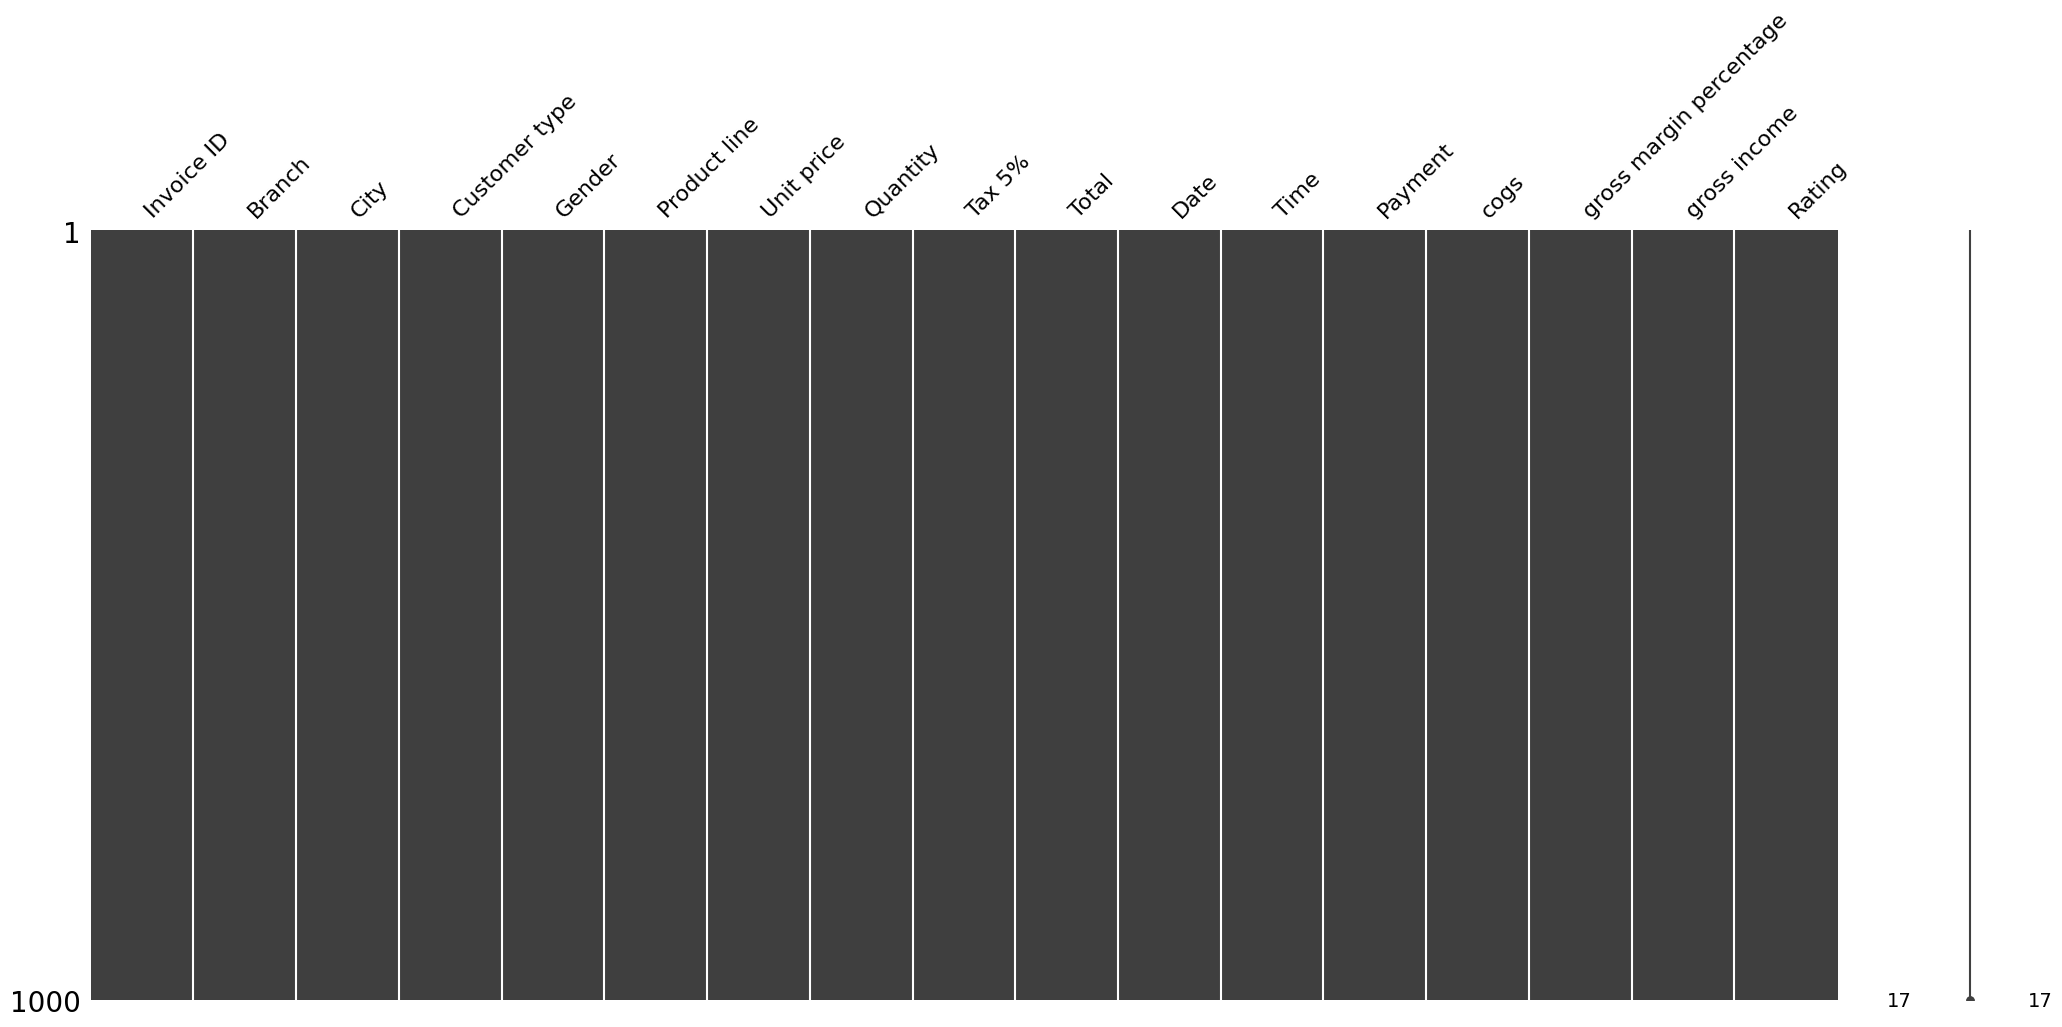

In [35]:
msno.matrix(dataset)
plt.show()

Com a resultat, es confirma que no hi ha valors nuls en cap columna del dataset. Això indica que no cal fer un tractament de valors faltants al preprocessat.

In [8]:
dataset['gross margin percentage'].unique()

array([4.76190476])

---

## 2. PREPROCESSAT

---

## 3. SELECCIÓ DE MODELS

---

## 4. CONCLUSIÓ